# 第 7  章  数据清洗和准备

在数据分析和建模的过程中，相当多的时间要用在数据准备上：加载、清理、
转换以及重塑。这些工作会占到分析师时间的 80%或更多。有时，存储在文件
和数据库中的数据的格式不适合某个特定的任务。许多研究者都选择使用通用
编程语言（如 Python、Perl、R 或 Java）或 UNIX 文本处理工具（如 sed 或
awk）对数据格式进行专门处理。幸运的是，pandas 和内置的 Python 标准库提
供了一组高级的、灵活的、快速的工具，可以让你轻松地将数据规变为想要的
格式。

如果你发现了一种本书或 pandas 库中没有的数据操作方式，请尽管在邮件列表
或 GitHub 网站上提出。实际上，pandas 的许多设计和实现都是由真实应用的
需求所驱动的。

在本章中，我会讨论处理缺失数据、重复数据、字符串操作和其它分析数据转
换的工具。下一章，我会关注于用多种方法合并、重塑数据集。

## 7.1 处理缺失数据

在许多数据分析工作中，缺失数据是经常发生的。pandas 的目标之一就是尽量
轻松地处理缺失数据。例如，pandas 对象的所有描述性统计默认都不包括缺失
数据。

缺失数据在 pandas 中呈现的方式有些不完美，但对于大多数用户可以保证功能
正常。对于数值数据，pandas 使用浮点值 NaN（Not a Number）表示缺失数
据。我们称其为哨兵值，可以方便的检测出来：

In [3]:
import pandas as pd
import numpy as np

string_data = pd.Series(['aardvark', 'artichoke', np.nan, 'avocado'])

In [4]:
string_data

0     aardvark
1    artichoke
2          NaN
3      avocado
dtype: object

In [5]:
string_data.isnull()

0    False
1    False
2     True
3    False
dtype: bool

在 pandas 中，我们采用了 R 语言中的惯用法，即将缺失值表示为 NA，它表示
不可用 not available。在统计应用中，NA 数据可能是不存在的数据或者虽然
存在，但是没有观察到（例如，数据采集中发生了问题）。当进行数据清洗以
进行分析时，最好直接对缺失数据进行分析，以判断数据采集的问题或缺失数
据可能导致的偏差。

Python 内置的 None 值在对象数组中也可以作为 NA：

In [7]:
string_data[0] = None

In [8]:
string_data.isnull()

0     True
1    False
2     True
3    False
dtype: bool

pandas 项目中还在不断优化内部细节以更好处理缺失数据，像用户 API 功能，
例如 pandas.isnull，去除了许多恼人的细节。表 7-1 列出了一些关于缺失数
据处理的函数。

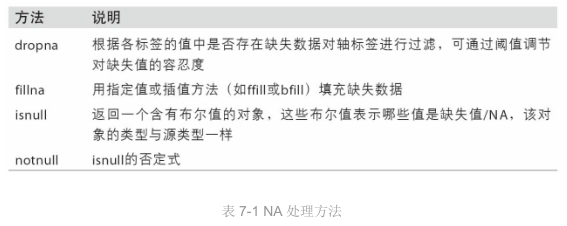

### 滤除缺失数据

过滤掉缺失数据的办法有很多种。你可以通过 pandas.isnull 或布尔索引的手
工方法，但 dropna 可能会更实用一些。对于一个 Series，dropna 返回一个仅
含非空数据和索引值的 Series：

In [9]:
from numpy import nan as NA

In [10]:
data = pd.Series([1, NA, 3.5, NA, 7])

In [11]:
data.dropna()

0    1.0
2    3.5
4    7.0
dtype: float64

In [12]:
data[data.notnull()]

0    1.0
2    3.5
4    7.0
dtype: float64

而对于 DataFrame 对象，事情就有点复杂了。你可能希望丢弃全 NA 或含有 NA
的行或列。dropna 默认丢弃任何含有缺失值的行：

In [13]:
data = pd.DataFrame([[1., 6.5, 3.], 
                     [1., NA, NA],
                     [NA, NA, NA], 
                     [NA, 6.5, 3.]])

In [14]:
data

,0,1,2
0,1.0,6.5,3.0
1,1.0,NaN,NaN
2,NaN,NaN,NaN
3,NaN,6.5,3.0


In [15]:
cleaned = data.dropna()

In [16]:
cleaned

,0,1,2
0,1.0,6.5,3.0


传入 how='all'将只丢弃全为 NA 的那些行：

In [17]:
data.dropna(how='all')

,0,1,2
0,1.0,6.5,3.0
1,1.0,NaN,NaN
3,NaN,6.5,3.0


用这种方式丢弃列，只需传入 axis=1 即可：

In [18]:
data[4] = NA

In [19]:
data

,0,1,2,4
0,1.0,6.5,3.0,NaN
1,1.0,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,6.5,3.0,NaN


In [20]:
data.dropna(axis=1, how='all')

,0,1,2
0,1.0,6.5,3.0
1,1.0,NaN,NaN
2,NaN,NaN,NaN
3,NaN,6.5,3.0


另一个滤除 DataFrame 行的问题涉及时间序列数据。假设你只想留下一部分观
测数据，可以用 thresh 参数实现此目的：

In [21]:
df = pd.DataFrame(np.random.randn(7, 3))

In [22]:
df.iloc[:4, 1] = NA

In [23]:
df.iloc[:2, 2] = NA

In [24]:
df

,0,1,2
0,-0.773202,NaN,NaN
1,0.086312,NaN,NaN
2,0.171299,NaN,0.067522
3,0.942929,NaN,1.459694
4,1.014618,2.058256,0.304696
5,0.917841,-0.082270,-1.636296
6,0.848256,1.229132,-1.082100


In [25]:
df.dropna()

,0,1,2
4,1.014618,2.058256,0.304696
5,0.917841,-0.082270,-1.636296
6,0.848256,1.229132,-1.082100


>thresh=`N`           要求一行至少具有`N`非NaN才能存活。前两行只有一个非NAN，所以被删除。（默认 `axis = 0`）

>thresh=`N` `axis =1` 要求一列至少具有`N`非NaN才能存活。

In [26]:
df.dropna(thresh=2)

,0,1,2
2,0.171299,NaN,0.067522
3,0.942929,NaN,1.459694
4,1.014618,2.058256,0.304696
5,0.917841,-0.082270,-1.636296
6,0.848256,1.229132,-1.082100


### 填充缺失数据

你可能不想滤除缺失数据（有可能会丢弃跟它有关的其他数据），而是希望通
过其他方式填补那些“空洞”。对于大多数情况而言，fillna 方法是最主要的
函数。通过一个常数调用 fillna 就会将缺失值替换为那个常数值：

In [27]:
df.fillna(0)

,0,1,2
0,-0.773202,0.000000,0.000000
1,0.086312,0.000000,0.000000
2,0.171299,0.000000,0.067522
3,0.942929,0.000000,1.459694
4,1.014618,2.058256,0.304696
5,0.917841,-0.082270,-1.636296
6,0.848256,1.229132,-1.082100


若是通过一个字典调用 fillna，就可以实现对不同的列填充不同的值：

In [28]:
df.fillna({1: 0.5, 2: 0})

,0,1,2
0,-0.773202,0.500000,0.000000
1,0.086312,0.500000,0.000000
2,0.171299,0.500000,0.067522
3,0.942929,0.500000,1.459694
4,1.014618,2.058256,0.304696
5,0.917841,-0.082270,-1.636296
6,0.848256,1.229132,-1.082100


fillna 默认会返回新对象，但也可以对现有对象进行就地修改：

In [29]:
_ = df.fillna(0, inplace=True)

In [30]:
df

,0,1,2
0,-0.773202,0.000000,0.000000
1,0.086312,0.000000,0.000000
2,0.171299,0.000000,0.067522
3,0.942929,0.000000,1.459694
4,1.014618,2.058256,0.304696
5,0.917841,-0.082270,-1.636296
6,0.848256,1.229132,-1.082100


对 reindexing 有效的那些插值方法也可用于 fillna：

In [31]:
df = pd.DataFrame(np.random.randn(6, 3))

In [32]:
df.iloc[2:, 1] = NA

In [33]:
df.iloc[4:, 2] = NA

In [34]:
df

,0,1,2
0,-1.861376,0.842391,-0.878438
1,-0.305261,1.507991,0.972810
2,2.190264,NaN,1.610349
3,-0.291934,NaN,0.848054
4,0.333649,NaN,NaN
5,1.553810,NaN,NaN


In [35]:
df.fillna(method='ffill')

,0,1,2
0,-1.861376,0.842391,-0.878438
1,-0.305261,1.507991,0.972810
2,2.190264,1.507991,1.610349
3,-0.291934,1.507991,0.848054
4,0.333649,1.507991,0.848054
5,1.553810,1.507991,0.848054


In [36]:
df.fillna(method='ffill', limit=2)

,0,1,2
0,-1.861376,0.842391,-0.878438
1,-0.305261,1.507991,0.972810
2,2.190264,1.507991,1.610349
3,-0.291934,1.507991,0.848054
4,0.333649,NaN,0.848054
5,1.553810,NaN,0.848054


只要有些创新，你就可以利用 fillna 实现许多别的功能。比如说，你可以传入
Series 的平均值或中位数：

In [37]:
data = pd.Series([1., NA, 3.5, NA, 7])

In [38]:
data.fillna(data.mean())

0    1.000000
1    3.833333
2    3.500000
3    3.833333
4    7.000000
dtype: float64

表 7-2 列出了 fillna 的参考。

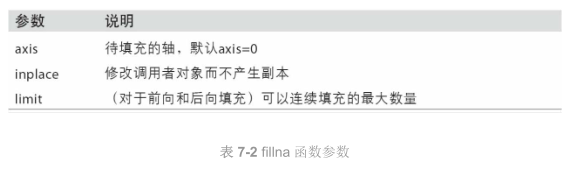

## 7.2 数据转换

本章到目前为止介绍的都是数据的重排。另一类重要操作则是过滤、清理以及
其他的转换工作。

### 移除重复数据

DataFrame 中出现重复行有多种原因。下面就是一个例子：

In [39]:
data = pd.DataFrame({'k1': ['one', 'two'] * 3 + ['two'],
                     'k2': [1, 1, 2, 3, 3, 4, 4]})

In [40]:
data

,k1,k2
0,one,1
1,two,1
2,one,2
3,two,3
4,one,3
5,two,4
6,two,4


DataFrame 的 duplicated 方法返回一个布尔型 Series，表示各行是否是重复行
（前面出现过的行）：

In [41]:
data.duplicated()

0    False
1    False
2    False
3    False
4    False
5    False
6     True
dtype: bool

还有一个与此相关的 drop_duplicates 方法，它会返回一个 DataFrame，重复
的数组会标为 False：??? 删除

In [42]:
data.drop_duplicates()

,k1,k2
0,one,1
1,two,1
2,one,2
3,two,3
4,one,3
5,two,4


这两个方法默认会判断全部列，你也可以指定部分列进行重复项判断。假设我
们还有一列值，且只希望根据 k1 列过滤重复项：

In [43]:
data['v1'] = range(7)

In [44]:
data.drop_duplicates(['k1'])

,k1,k2,v1
0,one,1,0
1,two,1,1


duplicated 和 drop_duplicates 默认保留的是第一个出现的值组合。传入
keep='last'则保留最后一个：

In [45]:
data.drop_duplicates(['k1', 'k2'], keep='last')

,k1,k2,v1
0,one,1,0
1,two,1,1
2,one,2,2
3,two,3,3
4,one,3,4
6,two,4,6


### 利用函数或映射进行数据转换

对于许多数据集，你可能希望根据数组、Series 或 DataFrame 列中的值来实现
转换工作。我们来看看下面这组有关肉类的数据：

In [60]:
data = pd.DataFrame({'food': ['bacon', 'pulled pork', 'bacon', 'Pastrami', 'corned beef', 'Bacon', 'pastrami', 'honey ham', 'nova lox'],
                     'ounces': [4, 3, 12, 6, 7.5, 8, 3, 5, 6]})

In [61]:
data

,food,ounces
0,bacon,4.0
1,pulled pork,3.0
2,bacon,12.0
3,Pastrami,6.0
4,corned beef,7.5
5,Bacon,8.0
6,pastrami,3.0
7,honey ham,5.0
8,nova lox,6.0


假设你想要添加一列表示该肉类食物来源的动物类型。我们先编写一个不同肉
类到动物的映射：

In [62]:
meat_to_animal = {
'bacon': 'pig',
'pulled pork': 'pig',
'pastrami': 'cow',
'corned beef': 'cow',
'honey ham': 'pig',
'nova lox': 'salmon'
}

Series 的 map 方法可以接受一个函数或含有映射关系的字典型对象，但是这里
有一个小问题，即有些肉类的首字母大写了，而另一些则没有。因此，我们还
需要使用 Series 的 str.lower 方法，将各个值转换为小写：

In [63]:
lowercased = data['food'].str.lower()

In [64]:
lowercased

0          bacon
1    pulled pork
2          bacon
3       pastrami
4    corned beef
5          bacon
6       pastrami
7      honey ham
8       nova lox
Name: food, dtype: object

In [65]:
data['animal'] = lowercased.map(meat_to_animal)

In [66]:
data

,food,ounces,animal
0,bacon,4.0,pig
1,pulled pork,3.0,pig
2,bacon,12.0,pig
3,Pastrami,6.0,cow
4,corned beef,7.5,cow
5,Bacon,8.0,pig
6,pastrami,3.0,cow
7,honey ham,5.0,pig
8,nova lox,6.0,salmon


我们也可以传入一个能够完成全部这些工作的函数：

In [67]:
data['food'].map(lambda x: meat_to_animal[x.lower()])

0       pig
1       pig
2       pig
3       cow
4       cow
5       pig
6       cow
7       pig
8    salmon
Name: food, dtype: object

使用 map 是一种实现元素级转换以及其他数据清理工作的便捷方式。

### 替换值

利用 fillna 方法填充缺失数据可以看做值替换的一种特殊情况。前面已经看
到，map 可用于修改对象的数据子集，而 replace 则提供了一种实现该功能的
更简单、更灵活的方式。我们来看看下面这个 Series：

In [68]:
data = pd.Series([1., -999., 2., -999., -1000., 3.])

In [69]:
data

0       1.0
1    -999.0
2       2.0
3    -999.0
4   -1000.0
5       3.0
dtype: float64

-999 这个值可能是一个表示缺失数据的标记值。要将其替换为 pandas 能够理
解的 NA 值，我们可以利用 replace 来产生一个新的 Series（除非传入
inplace=True）：

In [70]:
data.replace(-999, np.nan)

0       1.0
1       NaN
2       2.0
3       NaN
4   -1000.0
5       3.0
dtype: float64

如果你希望一次性替换多个值，可以传入一个由待替换值组成的列表以及一个
替换值：：

In [71]:
data.replace([-999, -1000], np.nan)

0    1.0
1    NaN
2    2.0
3    NaN
4    NaN
5    3.0
dtype: float64

要让每个值有不同的替换值，可以传递一个替换列表：

In [72]:
data.replace([-999, -1000], [np.nan, 0])

0    1.0
1    NaN
2    2.0
3    NaN
4    0.0
5    3.0
dtype: float64

传入的参数也可以是字典：

In [73]:
data.replace({-999: np.nan, -1000: 0})

0    1.0
1    NaN
2    2.0
3    NaN
4    0.0
5    3.0
dtype: float64

笔记：data.replace 方法与 data.str.replace 不同，后者做的是字符串的元
素级替换。我们会在后面学习 Series 的字符串方法。

### 重命名轴索引

跟 Series 中的值一样，轴标签也可以通过函数或映射进行转换，从而得到一个
新的不同标签的对象。轴还可以被就地修改，而无需新建一个数据结构。接下
来看看下面这个简单的例子：

In [74]:
data = pd.DataFrame(np.arange(12).reshape((3, 4)),
                    index=['Ohio', 'Colorado', 'New York'],
                    columns=['one', 'two', 'three', 'four'])

跟 Series 一样，轴索引也有一个 map 方法：

In [75]:
transform = lambda x: x[:4].upper()

In [76]:
data.index.map(transform)

Index(['OHIO', 'COLO', 'NEW '], dtype='object')

你可以将其赋值给 index，这样就可以对 DataFrame 进行就地修改：

In [77]:
data.index = data.index.map(transform)

In [78]:
data

,one,two,three,four
OHIO,0,1,2,3
COLO,4,5,6,7
NEW,8,9,10,11


如果想要创建数据集的转换版（而不是修改原始数据），比较实用的方法是
rename：

In [79]:
data.rename(index=str.title, columns=str.upper)

,ONE,TWO,THREE,FOUR
Ohio,0,1,2,3
Colo,4,5,6,7
New,8,9,10,11


特别说明一下，rename 可以结合字典型对象实现对部分轴标签的更新：

In [80]:
data.rename(index={'OHIO': 'INDIANA'},
            columns={'three': 'peekaboo'})

,one,two,peekaboo,four
INDIANA,0,1,2,3
COLO,4,5,6,7
NEW,8,9,10,11


rename 可以实现复制 DataFrame 并对其索引和列标签进行赋值。如果希望就地
修改某个数据集，传入 inplace=True 即可：

In [81]:
data.rename(index={'OHIO': 'INDIANA'}, inplace=True)

In [82]:
data

,one,two,three,four
INDIANA,0,1,2,3
COLO,4,5,6,7
NEW,8,9,10,11


### 离散化和面元划分

为了便于分析，连续数据常常被离散化或拆分为“面元”（bin）。假设有一组
人员数据，而你希望将它们划分为不同的年龄组：

In [83]:
ages = [20, 22, 25, 27, 21, 23, 37, 31, 61, 45, 41, 32]

接下来将这些数据划分为“18 到 25”、“26 到 35”、“35 到 60”以及“60
以上”几个面元。要实现该功能，你需要使用 pandas 的 cut 函数：

In [84]:
bins = [18, 25, 35, 60, 100]

In [85]:
cats = pd.cut(ages, bins)

In [86]:
cats

[(18, 25], (18, 25], (18, 25], (25, 35], (18, 25], ..., (25, 35], (60, 100], (35, 60], (35, 60], (25, 35]]
Length: 12
Categories (4, interval[int64]): [(18, 25] < (25, 35] < (35, 60] < (60, 100]]

pandas 返回的是一个特殊的 Categorical 对象。结果展示了 pandas.cut 划分
的面元。你可以将其看做一组表示面元名称的字符串。它的底层含有一个表示
不同分类名称的类型数组，以及一个 codes 属性中的年龄数据的标签：

In [87]:
cats.codes

array([0, 0, 0, 1, 0, 0, 2, 1, 3, 2, 2, 1], dtype=int8)

In [88]:
cats.categories

IntervalIndex([(18, 25], (25, 35], (35, 60], (60, 100]]
              closed='right',
              dtype='interval[int64]')

In [89]:
pd.value_counts(cats)

(18, 25]     5
(35, 60]     3
(25, 35]     3
(60, 100]    1
dtype: int64

pd.value_counts(cats)是 pandas.cut 结果的面元计数。

跟“区间”的数学符号一样，圆括号表示开端，而方括号则表示闭端（包
括）。哪边是闭端可以通过 right=False 进行修改：

In [90]:
pd.cut(ages, [18, 26, 36, 61, 100], right=False)

[[18, 26), [18, 26), [18, 26), [26, 36), [18, 26), ..., [26, 36), [61, 100), [36, 61), [36, 61), [26, 36)]
Length: 12
Categories (4, interval[int64]): [[18, 26) < [26, 36) < [36, 61) < [61, 100)]

你可 以通过传递一个列表或数组到 labels，设置自己的面元名称：

In [91]:
group_names = ['Youth', 'YoungAdult', 'MiddleAged', 'Senior']

In [92]:
pd.cut(ages, bins, labels=group_names)

[Youth, Youth, Youth, YoungAdult, Youth, ..., YoungAdult, Senior, MiddleAged, MiddleAged, YoungAdult]
Length: 12
Categories (4, object): [Youth < YoungAdult < MiddleAged < Senior]

如果向 cut 传入的是面元的数量而不是确切的面元边界，则它会根据数据的最
小值和最大值计算等长面元。下面这个例子中，我们将一些均匀分布的数据分
成四组：

In [99]:
data = np.random.rand(20)

In [100]:
pd.cut(data, 4, precision=2)

[(0.36, 0.57], (0.15, 0.36], (0.15, 0.36], (0.15, 0.36], (0.78, 0.99], ..., (0.78, 0.99], (0.57, 0.78], (0.57, 0.78], (0.36, 0.57], (0.78, 0.99]]
Length: 20
Categories (4, interval[float64]): [(0.15, 0.36] < (0.36, 0.57] < (0.57, 0.78] < (0.78, 0.99]]

选项 precision=2，限定小数只有两位。

qcut 是一个非常类似于 cut 的函数，它可以根据样本分位数对数据进行面元划
分。根据数据的分布情况，cut 可能无法使各个面元中含有相同数量的数据
点。而 qcut 由于使用的是样本分位数，因此可以得到大小基本相等的面元：

In [108]:
data = np.random.randn(1000) # Normally distributed

In [109]:
cats = pd.qcut(data, 4) # Cut into quartiles

In [110]:
cats

[(0.588, 3.492], (0.588, 3.492], (-0.701, -0.0426], (-3.2569999999999997, -0.701], (-0.0426, 0.588], ..., (-3.2569999999999997, -0.701], (-0.0426, 0.588], (-0.0426, 0.588], (-3.2569999999999997, -0.701], (-0.701, -0.0426]]
Length: 1000
Categories (4, interval[float64]): [(-3.2569999999999997, -0.701] < (-0.701, -0.0426] < (-0.0426, 0.588] < (0.588, 3.492]]

In [111]:
pd.value_counts(cats)

(0.588, 3.492]                   250
(-0.0426, 0.588]                 250
(-0.701, -0.0426]                250
(-3.2569999999999997, -0.701]    250
dtype: int64

与 cut 类似，你也可以传递自定义的分位数（0 到 1 之间的数值，包含端
点）：

In [112]:
pd.qcut(data, [0, 0.1, 0.5, 0.9, 1.])

[(1.336, 3.492], (-0.0426, 1.336], (-1.298, -0.0426], (-1.298, -0.0426], (-0.0426, 1.336], ..., (-1.298, -0.0426], (-0.0426, 1.336], (-0.0426, 1.336], (-3.2569999999999997, -1.298], (-1.298, -0.0426]]
Length: 1000
Categories (4, interval[float64]): [(-3.2569999999999997, -1.298] < (-1.298, -0.0426] < (-0.0426, 1.336] < (1.336, 3.492]]

本章稍后在讲解聚合和分组运算时会再次用到 cut 和 qcut，因为这两个离散化
函数对分位和分组分析非常重要。

### 检测和过滤异常值

过滤或变换异常值（outlier）在很大程度上就是运用数组运算。来看一个含有
正态分布数据的 DataFrame：

In [113]:
data = pd.DataFrame(np.random.randn(1000, 4))

In [114]:
data

,0,1,2,3
0,-0.549297,2.041855,0.359925,0.211967
1,-0.280539,-0.034942,-0.753434,3.350364
2,0.537430,1.718324,-0.100519,-0.396019
3,0.272063,0.632173,-0.019242,-0.763082
4,-1.953321,0.182335,-0.728093,-0.318126
5,0.826290,0.138703,0.944329,-2.189504
6,0.693109,-1.431636,0.347732,-0.140971
7,-0.716596,0.573058,0.529672,0.791378
8,-0.503273,0.928545,1.727547,0.683966
9,-1.038527,0.498609,-0.236698,-0.390233


In [115]:
data.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.005533,0.026021,-0.033102,0.012476
std,0.968512,0.973457,0.973454,0.977154
min,-3.105673,-2.779978,-3.411476,-3.136138
25%,-0.613746,-0.665051,-0.639054,-0.623199
50%,-0.019672,0.053106,0.006393,-0.000449
75%,0.664373,0.668701,0.633126,0.640811
max,3.052409,3.138137,3.318163,3.350364


假设你想要找出某列中绝对值大小超过 3 的值：

In [116]:
col = data[2]

In [117]:
col[np.abs(col) > 3]

799   -3.213412
872    3.318163
975   -3.411476
Name: 2, dtype: float64

要选出全部含有“超过 3 或－3 的值”的行，你可以在布尔型 DataFrame 中使
用 any 方法：

In [118]:
data[(np.abs(data) > 3).any(1)]

,0,1,2,3
1,-0.280539,-0.034942,-0.753434,3.350364
155,0.463544,0.253382,-0.107238,3.076353
486,-3.105673,-1.869005,-1.049046,-0.286047
487,0.532504,3.138137,-0.082646,1.077228
490,0.199415,0.054683,0.421412,3.082163
799,0.603079,-0.175545,-3.213412,-0.586805
810,3.052409,-1.257492,-0.552348,-0.366209
830,0.167696,-0.498024,1.421451,-3.136138
872,1.988076,0.703598,3.318163,-0.249967
975,-0.430771,-1.827080,-3.411476,1.501016


# 根据这些条件，就可以对值进行设置。下面的代码可以将值限制在区间－3 到 3
以内：

In [119]:
data[np.abs(data) > 3] = np.sign(data) * 3

In [120]:
data.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.005586,0.025883,-0.032795,0.012103
std,0.968015,0.973024,0.970388,0.975095
min,-3.000000,-2.779978,-3.000000,-3.000000
25%,-0.613746,-0.665051,-0.639054,-0.623199
50%,-0.019672,0.053106,0.006393,-0.000449
75%,0.664373,0.668701,0.633126,0.640811
max,3.000000,3.000000,3.000000,3.000000


根据数据的值是正还是负，np.sign(data)可以生成 1 和-1：

In [121]:
np.sign(data).head()

,0,1,2,3
0,-1.0,1.0,1.0,1.0
1,-1.0,-1.0,-1.0,1.0
2,1.0,1.0,-1.0,-1.0
3,1.0,1.0,-1.0,-1.0
4,-1.0,1.0,-1.0,-1.0


### 排列和随机采样

利用 numpy.random.permutation 函数可以轻松实现对 Series 或 DataFrame 的
列的排列工作（permuting，随机重排序）。通过需要排列的轴的长度调用
permutation，可产生一个表示新顺序的整数数组：

In [4]:
import pandas as pd
import numpy as np

df = pd.DataFrame(np.arange(5 * 4).reshape((5, 4)))
df

,0,1,2,3
0,0,1,2,3
1,4,5,6,7
2,8,9,10,11
3,12,13,14,15
4,16,17,18,19


In [5]:
sampler = np.random.permutation(5)

In [6]:
sampler

array([2, 0, 3, 1, 4])

然后就可以在基于 iloc 的索引操作或 take 函数中使用该数组了：

In [7]:
df.take(sampler)

,0,1,2,3
2,8,9,10,11
0,0,1,2,3
3,12,13,14,15
1,4,5,6,7
4,16,17,18,19


如果不想用替换的方式选取随机子集，可以在 Series 和 DataFrame 上使用
sample 方法：

In [8]:
df.sample(n=3)

,0,1,2,3
3,12,13,14,15
4,16,17,18,19
1,4,5,6,7


要通过替换的方式产生样本（允许重复选择），可以传递 replace=True 到
sample：

In [13]:
choices = pd.Series([5, 7, -1, 6, 4])

>想要获取子集时 n<= Series 长度 或者 DataFrame 的行数 (replace=False）

>n>= Series 长度 或者 DataFrame 的行数, replace=True

In [10]:
draws = choices.sample(n=10, replace=True)

In [11]:
draws

0    5
4    4
1    7
1    7
2   -1
3    6
0    5
3    6
0    5
0    5
dtype: int64

In [20]:
draws = choices.sample(n=5)

In [18]:
draws

2   -1
0    5
3    6
1    7
4    4
dtype: int64

### 计算指标/哑变量

另一种常用于统计建模或机器学习的转换方式是：将分类变量（categorical
variable）转换为“哑变量”或“指标矩阵”。

如果 DataFrame 的某一列中含有 k 个不同的值，则可以派生出一个 k 列矩阵或
DataFrame（其值全为 1 和 0）。pandas 有一个 get_dummies 函数可以实现该功
能（其实自己动手做一个也不难）。使用之前的一个 DataFrame 例子：

In [21]:
df = pd.DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'b'],
                   'data1': range(6)})

In [22]:
df

,key,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,b,5


In [23]:
pd.get_dummies(df['key'])

,a,b,c
0,0,1,0
1,0,1,0
2,1,0,0
3,0,0,1
4,1,0,0
5,0,1,0


有时候，你可能想给指标 DataFrame 的列加上一个前缀，以便能够跟其他数据
进行合并。get_dummies 的 prefix 参数可以实现该功能：

In [24]:
dummies = pd.get_dummies(df['key'], prefix='key')

In [25]:
df_with_dummy = df[['data1']].join(dummies)

In [26]:
df_with_dummy

,data1,key_a,key_b,key_c
0,0,0,1,0
1,1,0,1,0
2,2,1,0,0
3,3,0,0,1
4,4,1,0,0
5,5,0,1,0


如果 DataFrame 中的某行同属于多个分类，则事情就会有点复杂。看一下
MovieLens 1M 数据集，14 章会更深入地研究它：

In [27]:
mnames = ['movie_id', 'title', 'genres']

In [28]:
movies = pd.read_table('datasets/movielens/movies.dat',
                       sep='::',
                       header=None, names=mnames)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
movies[:10]

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


要为每个 genre 添加指标变量就需要做一些数据规整操作。首先，我们从数据
集中抽取出不同的 genre 值：

In [30]:
all_genres = []

In [32]:
for x in movies.genres:
    all_genres.extend(x.split('|'))

In [33]:
genres = pd.unique(all_genres)

In [34]:
genres

array(['Animation', "Children's", 'Comedy', 'Adventure', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Sci-Fi', 'Documentary', 'War', 'Musical', 'Mystery', 'Film-Noir',
       'Western'], dtype=object)

构建指标 DataFrame 的方法之一是从一个全零 DataFrame 开始：

In [35]:
zero_matrix = np.zeros((len(movies), len(genres)))

In [36]:
zero_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [37]:
len(movies)

3883

In [38]:
dummies = pd.DataFrame(zero_matrix, columns=genres)

现在，迭代每一部电影，并将 dummies 各行的条目设为 1。要这么做，我们使
用 dummies.columns 来计算每个类型的列索引：

In [39]:
gen = movies.genres[0]

In [41]:
gen.split('|')

['Animation', "Children's", 'Comedy']

In [42]:
dummies.columns.get_indexer(gen.split('|'))

array([0, 1, 2], dtype=int64)

然后，根据索引，使用.iloc 设定值：

In [43]:
for i, gen in enumerate(movies.genres):
    indices = dummies.columns.get_indexer(gen.split('|'))
    dummies.iloc[i, indices] = 1

然后，和以前一样，再将其与 movies 合并起来：

In [44]:
movies_windic = movies.join(dummies.add_prefix('Genre_'))

In [45]:
movies_windic.iloc[0]

movie_id                                       1
title                           Toy Story (1995)
genres               Animation|Children's|Comedy
Genre_Animation                                1
Genre_Children's                               1
Genre_Comedy                                   1
Genre_Adventure                                0
Genre_Fantasy                                  0
Genre_Romance                                  0
Genre_Drama                                    0
Genre_Action                                   0
Genre_Crime                                    0
Genre_Thriller                                 0
Genre_Horror                                   0
Genre_Sci-Fi                                   0
Genre_Documentary                              0
Genre_War                                      0
Genre_Musical                                  0
Genre_Mystery                                  0
Genre_Film-Noir                                0
Genre_Western       

笔记：对于很大的数据，用这种方式构建多成员指标变量就会变得非常慢。最
好使用更低级的函数，将其写入 NumPy 数组，然后结果包装在 DataFrame 中。

一个对统计应用有用的秘诀是：结合 get_dummies 和诸如 cut 之类的离散化函
数：

In [46]:
np.random.seed(12345)

In [47]:
values = np.random.rand(10)

In [48]:
values

array([0.92961609, 0.31637555, 0.18391881, 0.20456028, 0.56772503,
       0.5955447 , 0.96451452, 0.6531771 , 0.74890664, 0.65356987])

In [49]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]

In [50]:
pd.get_dummies(pd.cut(values, bins))

,"(0.0, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1.0]"
0,0,0,0,0,1
1,0,1,0,0,0
2,1,0,0,0,0
3,0,1,0,0,0
4,0,0,1,0,0
5,0,0,1,0,0
6,0,0,0,0,1
7,0,0,0,1,0
8,0,0,0,1,0
9,0,0,0,1,0


我们用 numpy.random.seed，使这个例子具有确定性。本书后面会介绍
pandas.get_dummies。

## 7.3 字符串操作

Python 能够成为流行的数据处理语言，部分原因是其简单易用的字符串和文本
处理功能。大部分文本运算都直接做成了字符串对象的内置方法。对于更为复
杂的模式匹配和文本操作，则可能需要用到正则表达式。pandas 对此进行了加
强，它使你能够对整组数据应用字符串表达式和正则表达式，而且能处理烦人
的缺失数据。

### 字符串对象方法

对于许多字符串处理和脚本应用，内置的字符串方法已经能够满足要求了。例
如，以逗号分隔的字符串可以用 split 拆分成数段：

In [51]:
val = 'a,b, guido'

In [52]:
val.split(',')

['a', 'b', ' guido']

split 常常与 strip 一起使用，以去除空白符（包括换行符）：

In [53]:
pieces = [x.strip() for x in val.split(',')]

In [54]:
pieces

['a', 'b', 'guido']

利用加法，可以将这些子字符串以双冒号分隔符的形式连接起来：

In [55]:
first, second, third = pieces

In [56]:
first + '::' + second + '::' + third

'a::b::guido'

但这种方式并不是很实用。一种更快更符合 Python 风格的方式是，向字符串
"::"的 join 方法传入一个列表或元组：

In [57]:
 '::'.join(pieces)

'a::b::guido'

其它方法关注的是子串定位。检测子串的最佳方式是利用 Python 的 in 关键
字，还可以使用 index 和 find：

注意 find 和 index 的区别：如果找不到字符串，index 将会引发一个异常（而
不是返回－1）：

In [58]:
val.index(':')

ValueError: substring not found

与此相关，count 可以返回指定子串的出现次数：

In [59]:
val.count(',')

2

replace 用于将指定模式替换为另一个模式。通过传入空字符串，它也常常用
于删除模式：

In [60]:
val.replace(',', '::')

'a::b:: guido'

In [61]:
val.replace(',', '')

'ab guido'

表 7-3 列出了 Python 内置的字符串方法。
这些运算大部分都能使用正则表达式实现（马上就会看到）。

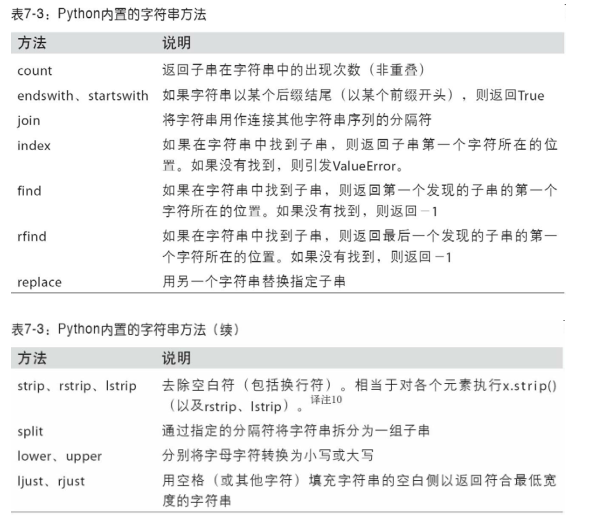

casefold 将字符转换为小写，并将任何特定区域的变量字符组合转换成一个通
用的可比较形式。

### 正则表达式

正则表达式提供了一种灵活的在文本中搜索或匹配（通常比前者复杂）字符串
模式的方式。正则表达式，常称作 `regex`，是根据正则表达式语言编写的字符
串。Python 内置的 `re` 模块负责对字符串应用正则表达式。我将通过一些例子
说明其使用方法。

笔记：正则表达式的编写技巧可以自成一章，超出了本书的范围。从网上和其
它书可以找到许多非常不错的教程和参考资料。

`re` 模块的函数可以分为三个大类：模式匹配、替换以及拆分。当然，它们之间
是相辅相成的。一个 `regex` 描述了需要在文本中定位的一个模式，它可以用于
许多目的。我们先来看一个简单的例子：假设我想要拆分一个字符串，分隔符
为数量不定的一组空白符（制表符、空格、换行符等）。描述一个或多个空白
符的 `regex` 是`\s+`：

In [62]:
import re

In [63]:
text = "foo bar\t baz \tqux"

In [64]:
re.split('\s+', text)

['foo', 'bar', 'baz', 'qux']

调用 re.split('\s+',text)时，正则表达式会先被编译，然后再在 text 上调
用其 split 方法。你可以用 re.compile 自己编译 regex 以得到一个可重用的
regex 对象：

In [66]:
regex = re.compile('\s+')
regex

re.compile(r'\s+', re.UNICODE)

In [67]:
regex.split(text)

['foo', 'bar', 'baz', 'qux']

如果只希望得到匹配 regex 的所有模式，则可以使用 findall 方法：

In [68]:
regex.findall(text)

[' ', '\t ', ' \t']

笔记：如果想避免正则表达式中不需要的转义（\），则可以使用原始字符串字
面量如 r'C:\x'（也可以编写其等价式'C:\x'）。

如果打算对许多字符串应用同一条正则表达式，强烈建议通过 re.compile 创建
regex 对象。这样将可以节省大量的 CPU 时间。

match 和 search 跟 findall 功能类似。findall 返回的是字符串中所有的匹配
项，而 search 则只返回第一个匹配项。match 更加严格，它只匹配字符串的首
部。来看一个小例子，假设我们有一段文本以及一条能够识别大部分电子邮件
地址的正则表达式：

In [69]:
text = """Dave dave@google.com
Steve steve@gmail.com
Rob rob@gmail.com
Ryan ryan@yahoo.com
"""
pattern = r'[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,4}'
# re.IGNORECASE makes the regex case-insensitive
regex = re.compile(pattern, flags=re.IGNORECASE)

对 text 使用 findall 将得到一组电子邮件地址：

In [70]:
regex.findall(text)

['dave@google.com', 'steve@gmail.com', 'rob@gmail.com', 'ryan@yahoo.com']

search 返回的是文本中第一个电子邮件地址（以特殊的匹配项对象形式返
回）。对于上面那个 regex，匹配项对象只能告诉我们模式在原字符串中的起
始和结束位置：

In [71]:
m = regex.search(text)

In [72]:
m

<re.Match object; span=(5, 20), match='dave@google.com'>

In [73]:
text[m.start():m.end()]

'dave@google.com'

regex.match 则将返回 None，因为它只匹配出现在字符串开头的模式：

In [74]:
print(regex.match(text))

None


相关的，sub 方法可以将匹配到的模式替换为指定字符串，并返回所得到的新
字符串：

In [75]:
print(regex.sub('REDACTED', text))

Dave REDACTED
Steve REDACTED
Rob REDACTED
Ryan REDACTED



假设你不仅想要找出电子邮件地址，还想将各个地址分成 3 个部分：用户名、
域名以及域后缀。要实现此功能，只需将待分段的模式的各部分用圆括号包起
来即可：

In [76]:
pattern = r'([A-Z0-9._%+-]+)@([A-Z0-9.-]+)\.([A-Z]{2,4})'

In [78]:
regex = re.compile(pattern, flags=re.IGNORECASE)
regex

re.compile(r'([A-Z0-9._%+-]+)@([A-Z0-9.-]+)\.([A-Z]{2,4})',
re.IGNORECASE|re.UNICODE)

由这种修改过的正则表达式所产生的匹配项对象，可以通过其 groups 方法返回
一个由模式各段组成的元组：

In [79]:
m = regex.match('wesm@bright.net')

In [80]:
m

<re.Match object; span=(0, 15), match='wesm@bright.net'>

In [81]:
m.groups()

('wesm', 'bright', 'net')

对于带有分组功能的模式，findall 会返回一个元组列表：

In [82]:
regex.findall(text)

[('dave', 'google', 'com'),
 ('steve', 'gmail', 'com'),
 ('rob', 'gmail', 'com'),
 ('ryan', 'yahoo', 'com')]

sub 还能通过诸如\1、\2 之类的特殊符号访问各匹配项中的分组。符号\1 对应
第一个匹配的组，\2 对应第二个匹配的组，以此类推：

In [83]:
print(regex.sub(r'Username: \1, Domain: \2, Suffix: \3', text))

Dave Username: dave, Domain: google, Suffix: com
Steve Username: steve, Domain: gmail, Suffix: com
Rob Username: rob, Domain: gmail, Suffix: com
Ryan Username: ryan, Domain: yahoo, Suffix: com



Python 中还有许多的正则表达式，但大部分都超出了本书的范围。表 7-4 是一
个简要概括。

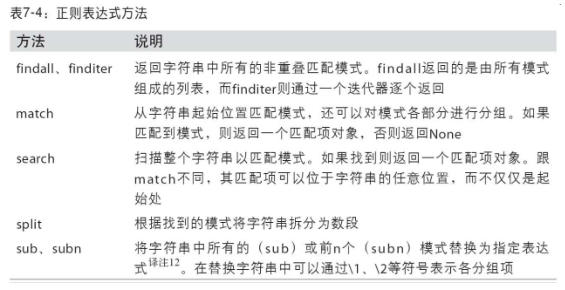

### pandas 的矢量化字符串函数

清理待分析的散乱数据时，常常需要做一些字符串规整化工作。更为复杂的情
况是，含有字符串的列有时还含有缺失数据：

In [85]:
data = {'Dave': 'dave@google.com', 'Steve':'steve@gmail.com','Rob': 'rob@gmail.com', 'Wes': np.nan}

In [86]:
data = pd.Series(data)

In [87]:
data

Dave     dave@google.com
Steve    steve@gmail.com
Rob        rob@gmail.com
Wes                  NaN
dtype: object

In [88]:
data.isnull()

Dave     False
Steve    False
Rob      False
Wes       True
dtype: bool

通过 data.map，所有字符串和正则表达式方法都能被应用于（传入 lambda 表
达式或其他函数）各个值，但是如果存在 NA（null）就会报错。为了解决这个
问题，Series 有一些能够跳过 NA 值的面向数组方法，进行字符串操作。通过
Series 的 str 属性即可访问这些方法。例如，我们可以通过 str.contains 检
查各个电子邮件地址是否含有"gmail"：

In [89]:
data.str.contains('gmail')

Dave     False
Steve     True
Rob       True
Wes        NaN
dtype: object

也可以使用正则表达式，还可以加上任意 re 选项（如 IGNORECASE）：

In [90]:
pattern

'([A-Z0-9._%+-]+)@([A-Z0-9.-]+)\\.([A-Z]{2,4})'

In [91]:
data.str.findall(pattern, flags=re.IGNORECASE)

Dave     [(dave, google, com)]
Steve    [(steve, gmail, com)]
Rob        [(rob, gmail, com)]
Wes                        NaN
dtype: object

有两个办法可以实现矢量化的元素获取操作：要么使用 str.get，要么在 str
属性上使用索引：

In [92]:
matches = data.str.match(pattern, flags=re.IGNORECASE)

In [93]:
matches

Dave     True
Steve    True
Rob      True
Wes       NaN
dtype: object

要访问嵌入列表中的元素，我们可以传递索引到这两个函数中：

In [94]:
matches.str.get(1)

Dave    NaN
Steve   NaN
Rob     NaN
Wes     NaN
dtype: float64

In [95]:
matches.str[0]

Dave    NaN
Steve   NaN
Rob     NaN
Wes     NaN
dtype: float64

你可以利用这种方法对字符串进行截取：

In [96]:
data.str[:5]

Dave     dave@
Steve    steve
Rob      rob@g
Wes        NaN
dtype: object

表 7-5 介绍了更多的 pandas 字符串方法。

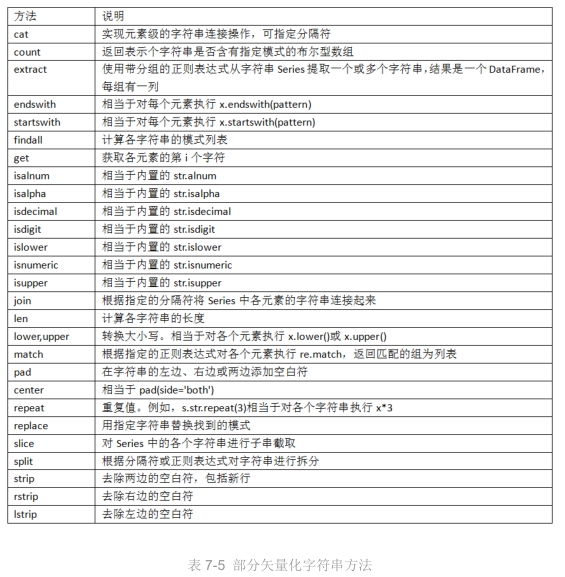

## 7.4  总结

高效的数据准备可以让你将更多的时间用于数据分析，花较少的时间用于准备
工作，这样就可以极大地提高生产力。我们在本章中学习了许多工具，但覆盖
并不全面。下一章，我们会学习 pandas 的聚合与分组。